# The Hot Neighbourhood Project

This project was developed as my Capstone Project in the Data Incubator program during 2016. The code is in python 2.7

This notebook contains the code for manipulating the data and building the ML prediction mode. There is some additional code that takes the results from this project and makes it into an interactive heroku app.

## Data
The data for this project is publically available from [the SF Open Data](https://data.sfgov.org/Public-Safety/Map-Crime-Incidents-from-1-Jan-2003/gxxq-x39z) and [Zillow](http://www.zillow.com/research/data/#bulk).



In [45]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

#read the Crime Data or SF
CrimeData = pd.read_csv("Map_Crime_Incidents.csv")
#Read the price data
PriceDatabyZipcode = pd.read_csv("Zip_MedianValuePerSqft_AllHomes.csv")


## Data Clean Up
In the first part of this notebook I reshape the data and clean it up, so that later on I can use it in my Logistic Regression model. The cleaned data will then be used to build a Logistic Regression model, which makes a prediction regarding how well a certain zipcode does in 2016 based on past crime data.

### Pricing Data
The Pricing Data from Zillow has separate columns for each month and year per region ID (zipcode). Using this data I calculate the price change for any zipcode in SF in each year (the difference between Jan past year to Jan present year).


### Crime Data
The crime data from the SF open data does not have zipcode information. Instead it has Police District information (which is not very useful) and longtitude and lattitude at which the crime occurred. I convert the lon and lat data to zipcodes, using Google Maps API. Ideally one would be able to convert each coordinate in the crime data to a zipcode, however the crime data contains 1934828 lines. It would be time consuming to request the zipcode for each line. Furthermore, that many requests would exceed the number of request available with the free version of Google API. Therefore instead I use an approximation: I create a grid that covers SF and request the zipcodes for each point on the grid. I then assign to each (lon, lat) pair in the data the point on the grid that is closest to it.

In [46]:
PriceDatabyZipcode[:10]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1244,1258,1265,1271,1275,1279,1290,1303,1303,1298
1,84654,60657,Chicago,IL,Chicago,Cook,2,134.0,134.0,133.0,...,277,277,277,277,278,280,281,283,284,284
2,84616,60614,Chicago,IL,Chicago,Cook,3,149.0,150.0,150.0,...,315,314,314,314,315,316,317,319,321,324
3,93144,79936,El Paso,TX,El Paso,El Paso,4,50.0,51.0,50.0,...,79,79,78,78,78,79,79,79,79,79
4,91733,77084,Houston,TX,Houston,Harris,5,38.0,38.0,37.0,...,76,76,77,77,78,78,78,79,80,80
5,84640,60640,Chicago,IL,Chicago,Cook,6,110.0,109.0,107.0,...,209,209,210,210,211,212,213,214,216,217
6,97564,94109,San Francisco,CA,San Francisco,San Francisco,7,279.0,281.0,280.0,...,1095,1093,1091,1093,1100,1105,1108,1109,1106,1100
7,62037,11226,New York,NY,New York,Kings,8,NaN,NaN,NaN,...,443,447,453,456,460,465,468,470,472,475
8,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,9,NaN,NaN,NaN,...,112,113,114,115,116,117,118,120,120,121
9,62087,11375,New York,NY,New York,Queens,10,NaN,NaN,NaN,...,517,518,519,520,523,524,523,522,526,531


In [47]:
#Reorganize the price data
#Reshape so that years are values and not rows
SFPriceDatabyZipcode2 = pd.melt(PriceDatabyZipcode, id_vars=["RegionID", "RegionName", "City",
                                             "State", "Metro", "CountyName", "SizeRank"], 
                  var_name="Date", value_name="Value")
#Limit to SF only
SFPriceData = SFPriceDatabyZipcode2[SFPriceDatabyZipcode2['City']=='San Francisco']


In [48]:
SFPriceData[:10]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Value
6,97564,94109,San Francisco,CA,San Francisco,San Francisco,7,1996-04,279.0
55,97565,94110,San Francisco,CA,San Francisco,San Francisco,56,1996-04,NaN
274,97576,94122,San Francisco,CA,San Francisco,San Francisco,275,1996-04,183.0
453,97567,94112,San Francisco,CA,San Francisco,San Francisco,454,1996-04,162.0
705,97569,94115,San Francisco,CA,San Francisco,San Francisco,706,1996-04,273.0
806,97571,94117,San Francisco,CA,San Francisco,San Francisco,807,1996-04,NaN
860,97575,94121,San Francisco,CA,San Francisco,San Francisco,861,1996-04,199.0
993,97572,94118,San Francisco,CA,San Francisco,San Francisco,994,1996-04,219.0
1010,97557,94102,San Francisco,CA,San Francisco,San Francisco,1011,1996-04,232.0
1099,97568,94114,San Francisco,CA,San Francisco,San Francisco,1100,1996-04,250.0


In [49]:
#Make a datetume object out of Date
pd.options.mode.chained_assignment = None #get rid of warnings
SFPriceData['Date2'] = pd.to_datetime(SFPriceData['Date'],infer_datetime_format=True)

In [81]:
#drop some columns
#RegionName is zipcode
SFPriceData2 = SFPriceData[['Date2', 'Metro', 'CountyName', 'Value', 'RegionName']]
SFPriceData2['Year'] = SFPriceData2['Date2'].apply(lambda x: x.year) 
SFPriceData2['Month'] = SFPriceData2['Date2'].apply(lambda x: x.month)

#This is what the pricing data looks like now
SFPriceData2[:10]

,Date2,Metro,CountyName,Value,RegionName,Year,Month
6,1996-04-01,San Francisco,San Francisco,279.0,94109,1996,4
55,1996-04-01,San Francisco,San Francisco,NaN,94110,1996,4
274,1996-04-01,San Francisco,San Francisco,183.0,94122,1996,4
453,1996-04-01,San Francisco,San Francisco,162.0,94112,1996,4
705,1996-04-01,San Francisco,San Francisco,273.0,94115,1996,4
806,1996-04-01,San Francisco,San Francisco,NaN,94117,1996,4
860,1996-04-01,San Francisco,San Francisco,199.0,94121,1996,4
993,1996-04-01,San Francisco,San Francisco,219.0,94118,1996,4
1010,1996-04-01,San Francisco,San Francisco,232.0,94102,1996,4
1099,1996-04-01,San Francisco,San Francisco,250.0,94114,1996,4


In [82]:
#calculate difference in price between jan and jan next year for each year in data, this will be the price change
 
#take only month of January
SFPriceData2Yearly = SFPriceData2[SFPriceData2['Month']==1]

#compute differnce between each two consequitive years
SFPriceData2YearlyWork = SFPriceData2Yearly[['RegionName', 'Year', 'Value']]

#drop years prior to 2004 (since we do not have crime data for those years)
SFPriceData2YearlyWork= SFPriceData2YearlyWork[SFPriceData2YearlyWork['Year'] >= 2004]


In [83]:
SFPriceData2YearlyPivot = SFPriceData2YearlyWork.pivot(index='RegionName', columns='Year', values='Value')

SFPriceData2YearlyPivot[:10]

Year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
RegionName,,,,,,,,,,,,,
94102,510.0,615.0,701.0,717.0,718.0,661.0,608.0,579.0,564.0,661.0,786.0,894.0,1015.0
94103,518.0,604.0,669.0,641.0,664.0,616.0,586.0,564.0,554.0,659.0,760.0,875.0,986.0
94105,655.0,680.0,761.0,800.0,831.0,814.0,725.0,699.0,706.0,871.0,1025.0,1115.0,1252.0
94107,546.0,626.0,709.0,711.0,741.0,662.0,618.0,597.0,607.0,709.0,846.0,917.0,1082.0
94108,716.0,711.0,788.0,864.0,843.0,845.0,740.0,674.0,698.0,842.0,926.0,1002.0,1182.0
94109,668.0,688.0,780.0,775.0,799.0,776.0,706.0,662.0,659.0,769.0,884.0,992.0,1105.0
94110,466.0,575.0,657.0,616.0,649.0,581.0,561.0,572.0,563.0,657.0,786.0,891.0,1017.0
94111,673.0,690.0,739.0,747.0,825.0,749.0,690.0,656.0,626.0,772.0,851.0,953.0,1024.0
94112,425.0,495.0,550.0,559.0,543.0,459.0,438.0,424.0,397.0,453.0,532.0,601.0,673.0


In [84]:
#this computes the price change from Jan to Jan between year and year-1

for year in SFPriceData2YearlyPivot.columns:
    if year -1 in SFPriceData2YearlyPivot.columns:
        SFPriceData2YearlyPivot[str(year)+'-'+str(year-1)] = SFPriceData2YearlyPivot[year] - SFPriceData2YearlyPivot[year-1]        



In [86]:
SFPriceData2YearlyPivot[:10]

Year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2008-2007,2009-2008,2010-2009,2011-2010,2012-2011,2013-2012,2014-2013,2015-2014,2016-2015,Zipcode
RegionName,,,,,,,,,,,,,,,,,,,,,
94102,510.0,615.0,701.0,717.0,718.0,661.0,608.0,579.0,564.0,661.0,...,1.0,-57.0,-53.0,-29.0,-15.0,97.0,125.0,108.0,121.0,94102
94103,518.0,604.0,669.0,641.0,664.0,616.0,586.0,564.0,554.0,659.0,...,23.0,-48.0,-30.0,-22.0,-10.0,105.0,101.0,115.0,111.0,94103
94105,655.0,680.0,761.0,800.0,831.0,814.0,725.0,699.0,706.0,871.0,...,31.0,-17.0,-89.0,-26.0,7.0,165.0,154.0,90.0,137.0,94105
94107,546.0,626.0,709.0,711.0,741.0,662.0,618.0,597.0,607.0,709.0,...,30.0,-79.0,-44.0,-21.0,10.0,102.0,137.0,71.0,165.0,94107
94108,716.0,711.0,788.0,864.0,843.0,845.0,740.0,674.0,698.0,842.0,...,-21.0,2.0,-105.0,-66.0,24.0,144.0,84.0,76.0,180.0,94108
94109,668.0,688.0,780.0,775.0,799.0,776.0,706.0,662.0,659.0,769.0,...,24.0,-23.0,-70.0,-44.0,-3.0,110.0,115.0,108.0,113.0,94109
94110,466.0,575.0,657.0,616.0,649.0,581.0,561.0,572.0,563.0,657.0,...,33.0,-68.0,-20.0,11.0,-9.0,94.0,129.0,105.0,126.0,94110
94111,673.0,690.0,739.0,747.0,825.0,749.0,690.0,656.0,626.0,772.0,...,78.0,-76.0,-59.0,-34.0,-30.0,146.0,79.0,102.0,71.0,94111
94112,425.0,495.0,550.0,559.0,543.0,459.0,438.0,424.0,397.0,453.0,...,-16.0,-84.0,-21.0,-14.0,-27.0,56.0,79.0,69.0,72.0,94112


In [90]:
#reshape back so that there is one row per each subsequent years and zipcode with yearly price as a value 

SFPriceData2YearlyPivot['Zipcode'] = SFPriceData2YearlyPivot.index
ByZipcodeYearlyBack = pd.melt(SFPriceData2YearlyPivot, id_vars=["Zipcode"], 
                  var_name="Year", value_name="Value")

#drop single year columns, we only want the value change
for year in range(2004, 2017):
    ByZipcodeYearlyBack = ByZipcodeYearlyBack[ByZipcodeYearlyBack['Year']!=year]

#set the year to be the 'end' year, meaning that the value for 2005 would be the change between jan 2004 to jan 2005    
ByZipcodeYearlyBack['Year']=ByZipcodeYearlyBack['Year'].apply(lambda x: int(str.split(x, '-')[0]))

ByZipcodeYearlyBack[:10]

,Zipcode,Year,Value
312,94102,2005,105.0
313,94103,2005,86.0
314,94105,2005,25.0
315,94107,2005,80.0
316,94108,2005,-5.0
317,94109,2005,20.0
318,94110,2005,109.0
319,94111,2005,17.0
320,94112,2005,70.0
321,94114,2005,81.0


In [104]:
#compute average change per year
AverageChangePerYEarZip = ByZipcodeYearlyBack.groupby('Year')['Value'].mean().reset_index()
AverageChangePerYEarZip[:10]

,Year,Value
0,2005,66.666667
1,2006,56.500000
2,2007,-1.708333
3,2008,22.208333
4,2009,-53.833333
5,2010,-43.041667
6,2011,-21.083333
7,2012,-10.708333
8,2013,95.833333
9,2014,112.166667


In [ ]:
#Geocoder
#get zipcodes from coordinates using Google Maps API
import geocoder
import ast
google_key = 'your_google_key_here'

#create a grid of coordinates covering SF, and request the zipcodes for coordinates in grid
X=np.linspace(-122.513642064,-122.389940,50)
Y=np.linspace(37.7078790224,37.806995736979587,50)
d={}
for x in X:
    for y in Y:
        d[(y,x)]= geocoder.google([y,x],method='reverse',key=google_key).postal


In [ ]:
#save to a csv file
with open('zippzopp.csv', 'wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in d.items():
        writer.writerow([key, value])

In [108]:
import ast
#load the saved csv file to use in order to translate lattitude and longtitude to zipcodes.
LonLatToZipcode = pd.read_csv("zippzopp.csv")
LonLatToZipcode['location'] = LonLatToZipcode['location'].apply(lambda x: ast.literal_eval(x))
#d is a dictionary that maps each (lon, lat) to zipcode
d = dict(zip(LonLatToZipcode['location'].values, LonLatToZipcode['zipcode'].values))

In [109]:
def zipCodifying(row):
    '''Get a row of data from the CrimeData DataFrame and return for the (lon, lat) the zipcode that best matches it'''
    x=row['X']
    y=row['Y']
    upperX = -122.389940
    lowerX = -122.513642064
    upperY = 37.806995736979587 #37.818259
    lowerY = 37.7078790224
    cells = 50
    XX=np.linspace(lowerX, upperX, cells)
    YY=np.linspace(lowerY, upperY, cells)
    
    delx=(upperX-lowerX)/50
    dely=(upperY-lowerY)/50
    inx=int(((x-lowerX)-((x-lowerX)%delx))/delx)
    iny=int(((y-lowerY)-((y-lowerY)%dely))/dely)
    
    if iny > 49:
        iny = 49
    if inx > 49:
        inx = 49

    if inx>=0 and inx<=49 and iny>=0 and iny<=49:
        if inx < 49 and (abs(x-XX[inx]) > abs(x-XX[inx+1])):
            inx = inx+1
        if iny < 49 and (abs(y-YY[iny]) > abs(y-YY[iny+1])):
            iny = iny+1
        newx=XX[inx]
        newy=YY[iny]
        #find the closest zipcode to the left that matches
        while np.isnan(d[(newy, newx)]) and inx >0:
            inx = inx-1
            newx = XX[inx]
        #move downward to the closest zipcode that has a non nan value
        while np.isnan(d[(newy, newx)]) and iny >0:
            iny = iny-1
            newy = YY[iny]
        zipcode=d[(newy,newx)] 
    else:
        zipcode=0
        
    return zipcode

In [110]:
CrimeData['zipcode']=CrimeData.apply(zipCodifying,axis=1)

In [111]:
CrimeData[:10]

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,zipcode
0,110914565,WARRANTS,WARRANT ARREST,Friday,05/29/2015 12:00:00 AM,16:42,SOUTHERN,"ARREST, BOOKED",BRYANT ST / 8TH ST,-122.406971,37.772527,"(37.7725273607571, -122.406970988225)",94103.0
1,11351210,MISSING PERSON,FOUND PERSON,Tuesday,06/14/2016 12:00:00 AM,08:55,BAYVIEW,NONE,1200 Block of 3RD ST,-122.389518,37.772468,"(37.7724682400061, -122.389517648036)",94158.0
2,120789988,MISSING PERSON,FOUND PERSON,Monday,05/16/2016 12:00:00 AM,00:41,INGLESIDE,NONE,WOOLSEY ST / UNIVERSITY ST,-122.412470,37.722659,"(37.7226585129212, -122.412469643631)",94134.0
3,140608681,ROBBERY,"ROBBERY, BODILY FORCE",Thursday,06/16/2016 12:00:00 AM,21:00,SOUTHERN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",94102.0
4,140608681,OTHER OFFENSES,VIOLATION OF MUNICIPAL CODE,Thursday,06/16/2016 12:00:00 AM,21:00,SOUTHERN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",94102.0
5,140608681,WARRANTS,WARRANT ARREST,Thursday,06/16/2016 12:00:00 AM,21:00,SOUTHERN,"ARREST, BOOKED",0 Block of UNITEDNATIONS PZ,-122.414318,37.779944,"(37.7799444052046, -122.414317857881)",94102.0
6,150020821,ASSAULT,ELDER ADULT OR DEPENDENT ABUSE (NOT EMBEZZLEME...,Friday,01/02/2015 12:00:00 AM,12:00,NORTHERN,NONE,300 Block of FULTON ST,-122.422536,37.778796,"(37.7787958771466, -122.422536478306)",94102.0
7,150020978,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,01/07/2015 12:00:00 AM,19:21,CENTRAL,"ARREST, BOOKED",MONTGOMERY ST / CHESTNUT ST,-122.405178,37.804764,"(37.80476375718, -122.405178220847)",94111.0
8,140009459,ARSON,ARSON,Saturday,01/04/2014 12:00:00 AM,03:52,NORTHERN,"ARREST, BOOKED",SACRAMENTO ST / POLK ST,-122.420875,37.791494,"(37.7914943051906, -122.420874632415)",94109.0
9,150021318,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,01/07/2015 12:00:00 AM,18:20,SOUTHERN,NONE,0 Block of FOLSOM ST,-122.390556,37.790475,"(37.7904750361645, -122.39055604599)",94105.0


In [112]:
CrimeData = CrimeData[CrimeData['Y'] < 90]

In [113]:
#organize Crime Data a bit more
ListofCrimes=CrimeData['Category'].value_counts().index.values
CrimeData['Year'] = CrimeData['Date'].apply(lambda x: int(str.split(str.split(x,'/')[2],' ')[0]))


In [ ]:
#get number of crimes of each type per year per zipcode
CrimeData_sub = CrimeData[['Descript', 'Year', 'zipcode']]


In [114]:
#get number of crimes of each type per year per zipcode
CrimeData_sub = CrimeData[['Descript', 'Year', 'zipcode']]
CrimeData_sub['Count'] = np.ones(CrimeData_sub.shape[0])
TotalPerZipcodePerYear = CrimeData_sub.groupby(['Year', 'zipcode'], as_index = False).agg({'Count': np.sum})
TotalPerYear = TotalPerZipcodePerYear.groupby(['Year'], as_index = False).agg({'Count': np.sum})



In [116]:
def beatMarket(zipcode,year):
    '''For a zipcode and a year returns 1 if the improvement in mean value of houses in the zipcode between January 1st of (year-1) and 
    January 1st of year is more than the mean improvement across districts'''
    yearlyMean= ByZipcodeYearlyBack[ByZipcodeYearlyBack['Year']==year]['Value'].mean()
    selectZipYear = (ByZipcodeYearlyBack['Zipcode']==zipcode) & (ByZipcodeYearlyBack['Year']==year)
    ZipMean = ByZipcodeYearlyBack[selectZipYear]['Value'].values[0]
    if ZipMean > yearlyMean:
        return 1
    else:
        return 0 

In [117]:
#get everything into one Dataframe, CombinedData
CrimeDataSmall = CrimeData[['Category', 'zipcode', 'Date']]
CrimeDataSmall['Year'] = CrimeDataSmall['Date'].apply(lambda x: int(str.split(str.split(x,'/')[2],' ')[0]))
frame_data=[]
target = []
m=0
numYears = 12 #there is data from 12 years

#all Zipcodes in the data
ZipNames=ByZipcodeYearlyBack['Zipcode'].value_counts().index.values

for i in ZipNames:
    for j in range(numYears):
        target.append(beatMarket(i,2005+j))
        Row_of_data=[i,j+2003]
        All_in_Year=CrimeDataSmall[CrimeDataSmall['Year']==j+2003]['Category'].value_counts()
        select_condition = (CrimeDataSmall['zipcode']==i) &(CrimeDataSmall['Year']==j+2003)
        Crime_Counts_in_Year= CrimeDataSmall[select_condition]['Category'].value_counts()
        percentofallinyear=sum(Crime_Counts_in_Year)*(1.0)/len(CrimeDataSmall[CrimeDataSmall['Year']==j+2003])
        Row_of_data.append(percentofallinyear)
        for k in ListofCrimes:
            if k in Crime_Counts_in_Year.index:
                Row_of_data.append((Crime_Counts_in_Year[k]*(1.0)/sum(Crime_Counts_in_Year)))
            else: #if there was no crime of this type in that year and district append 0
                Row_of_data.append(0)
        frame_data.append(Row_of_data)
    m=m+1
CombinedData=pd.DataFrame(columns=['zipcode', 'year','percent of all in year'] +list(ListofCrimes))
for i in range(len(frame_data)):
        CombinedData.loc[i]=(frame_data[i])
        

In [118]:
#There is one row per eachc combination of zipcode and year
CombinedData[:10]

,zipcode,year,percent of all in year,LARCENY/THEFT,OTHER OFFENSES,NON-CRIMINAL,ASSAULT,VEHICLE THEFT,DRUG/NARCOTIC,VANDALISM,...,LOITERING,SUICIDE,FAMILY OFFENSES,BAD CHECKS,BRIBERY,EXTORTION,"SEX OFFENSES, NON FORCIBLE",GAMBLING,PORNOGRAPHY/OBSCENE MAT,TREA
0,94158.0,2003.0,0.005384,0.291407,0.134496,0.058531,0.059776,0.189290,0.014944,0.057285,...,0.001245,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,94158.0,2004.0,0.003788,0.228164,0.151515,0.074866,0.058824,0.217469,0.019608,0.060606,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,94158.0,2005.0,0.003138,0.264574,0.118834,0.058296,0.042601,0.177130,0.033632,0.080717,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,94158.0,2006.0,0.002488,0.276968,0.134111,0.090379,0.075802,0.087464,0.014577,0.046647,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,94158.0,2007.0,0.003066,0.322275,0.127962,0.075829,0.068720,0.042654,0.023697,0.080569,...,0.002370,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,94158.0,2008.0,0.002753,0.362468,0.082262,0.077121,0.059126,0.066838,0.010283,0.066838,...,0.000000,0.000000,0.000000,0.002571,0.0,0.0,0.0,0.0,0.0,0.0
6,94158.0,2009.0,0.002996,0.343675,0.155131,0.062053,0.071599,0.064439,0.014320,0.083532,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,94158.0,2010.0,0.003655,0.317623,0.141393,0.067623,0.061475,0.032787,0.022541,0.079918,...,0.000000,0.000000,0.002049,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,94158.0,2011.0,0.002389,0.324921,0.138801,0.085174,0.088328,0.069401,0.012618,0.066246,...,0.000000,0.003155,0.000000,0.003155,0.0,0.0,0.0,0.0,0.0,0.0
9,94158.0,2012.0,0.003550,0.410000,0.116000,0.090000,0.034000,0.042000,0.014000,0.072000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
#Normalize: for each zipcode remove the mean across years
meansData= CombinedData.groupby(['zipcode']).mean()
def removeMean(row):
    '''Normalization function: 
    accepts a row of data (containing zipcode and year) and substracts the mean percentage
    of crime across all years for zipcode from crime percentage'''
    for i in range(len(row)-2):
        mean=meansData[meansData.index==row[0]].values[0][i+1]
        row[i+2]=row[i+2]-mean
    return row

#OriginalCombinedData = CombinedData.copy()
Newie=CombinedData.apply(removeMean,axis=1)


## Logistic Regression
Below I build a model that predicts how well each zipcode does in 2016 based on crime data from past years. As predictors I use the normalized percentage of crime occuring in that zipcode: both for all crime occuring in the zipcode and by type of crime, as well as the zipcode itself. What is predicted is whether or not the price for a given zipcode rises above the average for the enitire city of San Francisco.

In [121]:
#Create dummies columns:1 for the zipcode itself and 0 for all other zipcodes
m=0
datas=[]
numYears = 12 #there is data from 12 years
for i in ZipNames:
    for j in range(numYears):
        Row=[0]*m+[1]+[0]*(len(ZipNames)-m-1)
        datas.append(Row)
    m=m+1
    
dummies=pd.DataFrame(columns=list(ZipNames))
for i in range(len(datas)):
        dummies.loc[i]=(datas[i])
        

In [125]:
dummies[:13]

,94158,94134,94103,94105,94107,94108,94109,94110,94111,94112,...,94118,94121,94122,94123,94124,94127,94131,94132,94133,94102
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
        
#Create train data- add the dummie columns for all the zipcodes
train=pd.concat([Newie.ix[:,2:],dummies],axis=1)


In [127]:
train.head()

,percent of all in year,LARCENY/THEFT,OTHER OFFENSES,NON-CRIMINAL,ASSAULT,VEHICLE THEFT,DRUG/NARCOTIC,VANDALISM,WARRANTS,BURGLARY,...,94118,94121,94122,94123,94124,94127,94131,94132,94133,94102
0,0.002000,-0.032292,0.007884,-0.018146,-0.002301,0.099177,-0.003778,-0.010246,0.014349,-0.016161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000404,-0.095535,0.024904,-0.001810,-0.003254,0.127356,0.000886,-0.006926,0.009807,-0.016967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.000246,-0.059125,-0.007777,-0.018380,-0.019476,0.087017,0.014910,0.013186,0.005143,0.029938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.000896,-0.046731,0.007499,0.013703,0.013725,-0.002649,-0.004145,-0.020884,-0.018396,0.042293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.000318,-0.001424,0.001351,-0.000847,0.006643,-0.047459,0.004975,0.013037,-0.002168,0.008973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0.656200846945
21.0


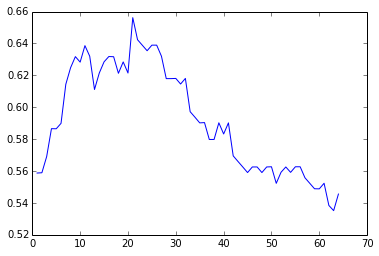

In [128]:
%matplotlib inline

#Logistic Regression
#Check mean cross validation scores for various choices of feature selections for logistic regression
from sklearn import feature_selection
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.linear_model import *
import pylab

#x is [1,.....,len(train.columns)]
x =  np.linspace(1,len(train.columns),len(train.columns))
y=[]
clf=Pipeline([('scaler', StandardScaler()), ('logistic', LogisticRegression())])
#select a+1 features every time and check prediction
for a in range(len(train.columns)):
    #select best a+1 features
    fs=feature_selection.SelectKBest(feature_selection.f_classif,k=a+1)
    #fit the data
    X_train=fs.fit_transform(train,target)
    #compute cross validation 5 times
    cv=KFold(len(train),5,shuffle=True, random_state=20)
    scores=cross_val_score(clf,X_train,target,cv=cv) #cross validation scores
    y.append(np.mean(scores))
pylab.plot(x,y)
print(max(y))
print x[np.array(y).argmax(axis=0)]

In [130]:
fs=feature_selection.SelectKBest(feature_selection.f_classif,k=21) #21 features gives best result
X_train = fs.fit_transform(train,target)
scaler=StandardScaler().fit(X_train)
X=scaler.transform(X_train)
l=LogisticRegression().fit(X, target)

#mathch the F score to the crime
DataCoefficients = pd.DataFrame({'Variables': train.columns,'F_Scores': fs.scores_}) 
DataCoefficients = DataCoefficients.sort('F_Scores', ascending=[0]) #sort by F-Score

#mathch the L coefficient to the crime
ChosenFeatures=pd.Series(train.columns)[pd.Series(train.columns).
                                        apply(lambda x: x in set(DataCoefficients['Variables'].values[:21]))]
LCoefficients = pd.DataFrame({'Feature':ChosenFeatures, 'L_Coef':l.coef_[0]})
LCoefficients['LAbsValue'] = LCoefficients['L_Coef'].apply(lambda x: abs(x))
LCoefficients= LCoefficients.sort('LAbsValue', ascending = [0]) #sort


/Library/Python/2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


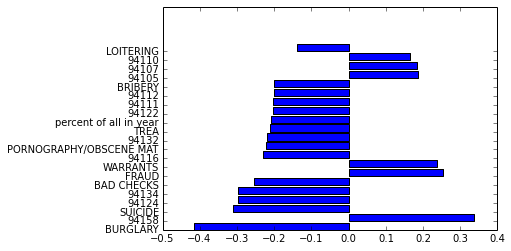

In [131]:
y_pos = np.arange(len(LCoefficients['Feature'].values))
plt.barh(y_pos, LCoefficients['L_Coef'].values)
plt.yticks(y_pos, LCoefficients['Feature'].values)
plt.savefig('LCoefficients.png', bbox_inches='tight')

In [141]:
#get prediction for 2016
#For that we need to transform the crime data from 2015 in the same way in which we transformed the rest of the data 

#CrimeDataSmall = CrimeData[['Category', 'zipcode', 'Date']]
#CrimeDataSmall['Year'] = CrimeDataSmall['Date'].apply(lambda x: int(str.split(str.split(x,'/')[2],' ')[0]))
frame_data_2015=[]
target_2015 = []

for i in ZipNames:
        Row_of_data=[i,2015]
        All_in_Year=CrimeDataSmall[CrimeDataSmall['Year']==2015]['Category'].value_counts()
        select_condition = (CrimeDataSmall['zipcode']==i) &(CrimeDataSmall['Year']==2015)
        Crime_Counts_in_Year= CrimeDataSmall[select_condition]['Category'].value_counts()
        percentofallinyear=sum(Crime_Counts_in_Year)*(1.0)/len(CrimeDataSmall[CrimeDataSmall['Year']==2015])
        Row_of_data.append(percentofallinyear)
        for k in ListofCrimes:
            if k in Crime_Counts_in_Year.index:
                Row_of_data.append((Crime_Counts_in_Year[k]*(1.0)/sum(Crime_Counts_in_Year)))
            else: #if there was no crime of this type in that year and district append 0
                Row_of_data.append(0)
        frame_data_2015.append(Row_of_data)
    
CombinedData_2015=pd.DataFrame(columns=['zipcode', 'year','percent of all in year'] +list(ListofCrimes))
for i in range(len(frame_data_2015)):
        CombinedData_2015.loc[i]=(frame_data_2015[i])
        
        
#Remove means for same zipcode across years

Newie_2015=CombinedData_2015.apply(removeMean,axis=1)

In [144]:
CombinedData_2015.shape

(24, 42)

In [145]:
#dummies
m=0
datas=[]
#numYears = 12 #there is data from 12 years
for i in ZipNames:
    #for j in range(numYears):
    Row=[0]*m+[1]+[0]*(len(ZipNames)-m-1)    
    datas.append(Row)
    m=m+1
    
dummies=pd.DataFrame(columns=list(ZipNames))
for i in range(len(datas)):
    dummies.loc[i]=(datas[i])
                
#Create train data
data_2015=pd.concat([Newie_2015.ix[:,2:],dummies],axis=1)


X_train = fs.transform(data_2015)
X_2015=scaler.transform(X_train)
result  = l.predict(X_2015)

In [146]:
result

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1])

In [147]:
#make the prediction into a dataframe and save into a csv file
predicted_2016 = pd.DataFrame({'Zipcode': ZipNames, 'BM': result})
predicted_2016.to_csv('2016_predict.csv')

## Prep Results for Deployment
This part isn't a part of the data analysis, however I used the code below to prepare some files needed for the deployed app on Heroku.

In [149]:
#create small csv files for visualizations. The files are later read from in the deployed version to make vizualizations
mean_yearly_change = ByZipcodeYearlyBack.groupby(['Year']).mean()
mean_yearly_change = mean_yearly_change.reset_index()
mean_yearly_change = mean_yearly_change[['Year', 'Value']]
mean_yearly_change.columns = ['Year', 'mean']
ByZipcodeYearlyBack2 = ByZipcodeYearlyBack.merge(mean_yearly_change, 'left', ['Year'])
ByZipcodeYearlyBack2['Beat Market'] = ByZipcodeYearlyBack2['mean'] < ByZipcodeYearlyBack2['Value']
ByZipcodeYearlyBack2['Beat Market Numeric'] = ByZipcodeYearlyBack2['Beat Market'].apply(lambda x: int(x == True))

In [150]:
ByZipcodeYearlyBack2.head()

,Zipcode,Year,Value,mean,Beat Market,Beat Market Numeric
0,94102,2005,105.0,66.666667,True,1
1,94103,2005,86.0,66.666667,True,1
2,94105,2005,25.0,66.666667,False,0
3,94107,2005,80.0,66.666667,True,1
4,94108,2005,-5.0,66.666667,False,0


In [151]:
#create a dictionary of BeatMarket by zipcode and year from ByZipcodeYearlyBack2
zipcode_year_dict = {}
for index, row in ByZipcodeYearlyBack2.iterrows():
    _year = row['Year']
    _zipcode = row['Zipcode']
    _beat = row['Beat Market Numeric']
    if _year in zipcode_year_dict.keys():
        zipcode_year_dict[_year][_zipcode] =_beat
    else:
        zipcode_year_dict[_year] = {_zipcode : _beat}

#make color dict-this will later be used with the Folium maps
color_dict = {}
for year in zipcode_year_dict.keys():
    color_dict[year] = {}
    for zipcode in zipcode_year_dict[year].keys():
        #print zipcode_year_dict[year][zipcode]
        if zipcode_year_dict[year][zipcode]==1:
            #red is this color, e.g. beat market
             color_dict[year][zipcode] = '#008000'
        else:
             color_dict[year][zipcode] = '#ff0000' 
  
    

In [153]:
import json
with open('Colors.txt', 'w') as outfile:
    json.dump(color_dict, outfile)

In [155]:
zipcode_year_dict.keys()

[2016, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

In [156]:
CrimeDataByYearPerZipcode = CrimeDataSmall.groupby(['Year', 'zipcode'])['zipcode'].agg(['count'])
CrimeYearZipcode = CrimeDataByYearPerZipcode.reset_index()
CrimeYearCount = CrimeYearZipcode.groupby(['Year'])['count'].agg(['sum'])
CrimeYearCount = CrimeYearCount.reset_index()
CrimeYearZipcode = CrimeYearZipcode.merge(CrimeYearCount, 'left', ['Year'])
CrimeYearZipcode['% in Zipcode'] = CrimeYearZipcode['count']*(1.0)/CrimeYearZipcode['sum']
CrimeYearZipcode.columns = ['Year', 'Zipcode', 'count', 'sum', 'percentage']
PriceChange = ByZipcodeYearlyBack2
PriceChange.merge(CrimeYearZipcode, 'left', ['Zipcode', 'Year'])
PriceChange.to_csv('useful.csv')